In [2]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as functional
import test_cuda
from geraChar import *
device = test_cuda.device
import matplotlib.pyplot as plt

In [3]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=63, out_features=50)
        self.layer_2 = nn.Linear(in_features=50, out_features=16)
        self.tanh = nn.Tanh() 

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_2(self.tanh(self.layer_1(x)))

loss_fn = nn.MSELoss()

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [4]:
config_samples_noise = [
    #samples, ruido
    [[16,0]],   #RNA0
    [[16,0],[16,10],], #RNA1
    [[16,0],[16,10],[16,20]],  #RNA2
    [[16,0],[16,10],[16,20],[16,30]],   #RNA3
    [[16,0],[16,10],[16,20],[16,30],[16,40],],   #RNA4
    [[16,0],[16,10],[16,20],[16,30],[16,40],[16,50],],   #RNA5
]

nns = {}

y_labels = np.arange(0,16).reshape(16,1)

list_seeds = [1,10,30]

for nn_num,config in enumerate(config_samples_noise):
    print(f"\n\n\{'=*'*15} {f'RNA{nn_num}'} {'=*'*15}")
    nns[nn_num] = {}
    for num_seeds in list_seeds:
        is_train_over =  False
        print(f"{'=*'*10} {f'Number of seeds = {num_seeds}'} {'=*'*10}")
        nns[nn_num][num_seeds] = {}
        torch.manual_seed(num_seeds)
        nns[nn_num][num_seeds]['mlp'] = MLP().to(device)
        nns[nn_num][num_seeds]['optimizer'] = torch.optim.SGD(params=nns[nn_num][num_seeds]['mlp'].parameters(), lr=0.7,momentum=0.0)
        X_train = []
        X_test = []
        Y_train = []
        Y_test = []
        var=  0
        for samples, noise in config:
            for seed in range(num_seeds):    
                np.random.seed(seed)
                rng = np.random.default_rng(seed=seed)
                chosen_numbers =  rng.choice(16, samples,replace=False)
                x_train = gchar_ruido(geraChar().reshape((16,63)),noise)#[chosen_numbers]
                x_test = gchar_ruido(geraChar().reshape((16,63)),noise)#[chosen_numbers]
                X_train.append(x_train)
                X_test.append(x_test)
                y = y_labels.reshape(samples,1)#[chosen_numbers]
                Y_train.append(y)
                Y_test.append(y)
            
        X_train = torch.from_numpy(np.concatenate(X_train,axis=0)).type(torch.float32).to(device)
        X_test = torch.from_numpy(np.concatenate(X_test,axis=0)).type(torch.float32).to(device)
        Y_train  = torch.from_numpy(np.concatenate(Y_train,axis=0)).squeeze().long().to(device)
        Y_test  = torch.from_numpy(np.concatenate(Y_test,axis=0)).squeeze().long().to(device)
        Y_train_oh = functional.one_hot(Y_train.squeeze()).type(torch.float32).to(device)
        Y_test_oh = functional.one_hot(Y_test.squeeze()).type(torch.float32).to(device)

        mlp = nns[nn_num][num_seeds]['mlp']
        optimizer = nns[nn_num][num_seeds]['optimizer']

        epochs = 1000

        train_acc_history = torch.zeros(epochs,dtype=torch.float32)
        train_loss_history = torch.zeros(epochs,dtype=torch.float32)
        test_acc_history = torch.zeros(epochs,dtype=torch.float32)

        for epoch in range(epochs):
            ### Training
            mlp.train()

            y_logits = mlp(X_train)

            y_pred = torch.argmax(y_logits,dim=1)
            
            # 2. Calculate loss/accuracy
            loss = loss_fn(y_logits, 
                        Y_train_oh)

            train_loss_history[epoch] = loss

            acc = accuracy_fn(y_true=Y_train, 
                            y_pred=y_pred) 
            train_acc_history[epoch] = acc
            # 3. Optimizer zero grad
            optimizer.zero_grad()

            # 4. Loss backwards
            loss.backward()

            # 5. Optimizer step
            optimizer.step()

            mlp.eval()
            with torch.inference_mode():
                # 1. Forward pass
                test_logits = mlp(X_test)
                test_pred = torch.argmax(test_logits,dim=1)
                # 2. Caculate loss/accuracy
                test_loss = loss_fn(test_logits,
                                    Y_test_oh)
                test_acc = accuracy_fn(y_true=Y_test,
                                    y_pred=test_pred)
                
                test_acc_history[epoch] = test_acc


            if epoch >= 100:
                    var = torch.std(train_loss_history[epoch-100:epoch]).item()
                    if var < 1e-6:
                        is_train_over = True
                        print(f"Train is over after {epoch} epochs")


            # Print out what's happening every 100 epochs
            if (epoch % 100 == 0) or is_train_over:
                print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%, var: {var:.2f}")
            
            if is_train_over or (epoch == epochs -1):
                nns[nn_num][num_seeds]['train_acc_history'] = train_acc_history[:epoch]
                nns[nn_num][num_seeds]['test_acc_history'] = test_acc_history[:epoch]
                break



\=*=*=*=*=*=*=*=*=*=*=*=*=*=*=* RNA0 =*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
=*=*=*=*=*=*=*=*=*=* Number of seeds = 1 =*=*=*=*=*=*=*=*=*=*
Epoch: 0 | Loss: 0.10769, Accuracy: 6.25% | Test loss: 0.06897, Test acc: 12.50%, var: 0.00
Epoch: 100 | Loss: 0.00923, Accuracy: 100.00% | Test loss: 0.00912, Test acc: 100.00%, var: 0.02
Epoch: 200 | Loss: 0.00335, Accuracy: 100.00% | Test loss: 0.00332, Test acc: 100.00%, var: 0.00
Epoch: 300 | Loss: 0.00126, Accuracy: 100.00% | Test loss: 0.00125, Test acc: 100.00%, var: 0.00
Epoch: 400 | Loss: 0.00039, Accuracy: 100.00% | Test loss: 0.00038, Test acc: 100.00%, var: 0.00
Epoch: 500 | Loss: 0.00009, Accuracy: 100.00% | Test loss: 0.00009, Test acc: 100.00%, var: 0.00
Epoch: 600 | Loss: 0.00002, Accuracy: 100.00% | Test loss: 0.00002, Test acc: 100.00%, var: 0.00
Epoch: 700 | Loss: 0.00000, Accuracy: 100.00% | Test loss: 0.00000, Test acc: 100.00%, var: 0.00
Train is over after 793 epochs
Epoch: 793 | Loss: 0.00000, Accuracy: 100.00% | Test loss: 0.00000

In [5]:
list_noises = [0,10,20,30,40,50]
for nn_num,config in enumerate(config_samples_noise):
    print(f"{'=*'*15} {f'RNA{nn_num}'} {'=*'*15}")
    for num_seeds in list_seeds:
        mlp = nns[nn_num][num_seeds]['mlp']
        list_acc = []
        nns[nn_num][num_seeds]['acc_noise'] = []
        for noise in list_noises:
            X_test = []
            Y_test = []
            for k in range(10):
                x_test = gchar_ruido(geraChar().reshape((16,63)),noise)
                X_test.append(x_test)
                y = y_labels.reshape(samples,1)
                Y_test.append(y)
            X_test = torch.from_numpy(np.concatenate(X_test,axis=0)).type(torch.float32).to(device)
            Y_test  = torch.from_numpy(np.concatenate(Y_test,axis=0)).squeeze().long().to(device)
            Y_test_oh = functional.one_hot(Y_test.squeeze()).type(torch.float32).to(device)
            mlp.eval()
            with torch.inference_mode():
                # 1. Forward pass
                test_logits = mlp(X_test)
                test_pred = torch.argmax(test_logits,dim=1)
                test_acc = accuracy_fn(y_true=Y_test,
                                    y_pred=test_pred)
            nns[nn_num][num_seeds]['acc_noise'].append(test_acc)

=*=*=*=*=*=*=*=*=*=*=*=*=*=*=* RNA0 =*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=* RNA1 =*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=* RNA2 =*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=* RNA3 =*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=* RNA4 =*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=* RNA5 =*=*=*=*=*=*=*=*=*=*=*=*=*=*=*


In [ ]:
import pickle

def save_pickle(var, path: str):
    # Salva variável com o pickle
    with open(path, 'wb') as handle:
        pickle.dump(var, handle, protocol=pickle.HIGHEST_PROTOCOL)


def load_pickle(path: str):
    # Carrega variável com o pickle
    with open(path, 'rb') as handle:
        var = pickle.load(handle)
        return var
    
save_pickle(nns,'./nns.pickle')

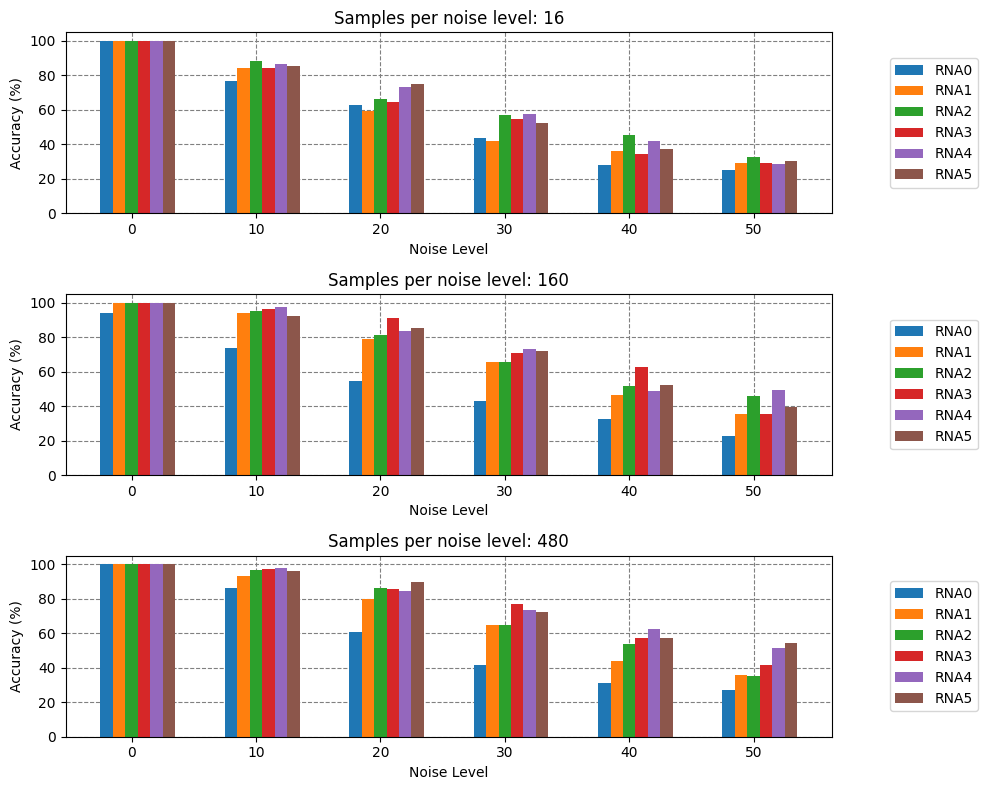

In [ ]:
fig, axes = plt.subplots(3,1,figsize=(10,8),tight_layout=True,dpi=100)
x = 10*np.arange(6)
width = 1
for k,num_seeds in enumerate(list_seeds):
    axes[k].set_axisbelow(True)
    axes[k].grid(color='gray', linestyle='dashed')    
    for nn_num,config in enumerate(config_samples_noise):
        y = nns[nn_num][num_seeds]['acc_noise']
        axes[k].bar(x +width*(nn_num-2),y,width = width,label=f'RNA{nn_num}')
        
    #axes[k].legend()
    axes[k].legend(loc='center right',bbox_to_anchor=(1.2, 0.5))
    axes[k].set_xlabel("Noise Level")
    axes[k].set_ylabel("Accuracy (%)")
    axes[k].set_title(f"Samples per noise level: {16*num_seeds}")